# Can Beta Dispersion be used for Market-Timing?
    https://ssrn.com/abstract=2984889

In [1]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
library('lubridate')
library('schoRsch')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [10]:
lookBack<-30

nifty<-sqlQuery(lcon, sprintf("select TIME_STAMP, PX_CLOSE from BHAV_INDEX where INDEX_NAME='NIFTY 100' and time_stamp >= '2010-01-01'"))
niftyXts<-xts(nifty[,2], as.Date(nifty[,1]))
niftyRet<-dailyReturn(niftyXts)
names(niftyRet)<-c("RET")

niftyRet$K<-NA
niftyRet$S<-NA
niftyRet$SD<-NA
niftyRet$MEDIAN<-NA
niftyRet$MEAN<-NA
niftyRet$MEAN_1<-NA
niftyRet$MEAN_5<-NA

In [11]:
for(i in (lookBack+1):length(nifty[,1])){
     dt<-as.Date(nifty[i,1])
     eom<-as.Date(sprintf("%s-%d", format(dt, "%Y-%m"), days_in_month(dt)))

     constituents<-sqlQuery(lcon, sprintf("select SYMBOL from INDEX_CONST_HISTORY
                              where (INDEX_NAME='NIFTY 50' or INDEX_NAME='NIFTY NEXT 50')
                              and SYMBOL not like '%%DVR'
                              and TIME_STAMP='%s'", eom))$SYMBOL
          
     if(length(constituents) < 100){
          print(sprintf("SKIPPING %s", dt))
               next
     }
    
     betas<-c()
     for(iConst in constituents){
          lastRet<-sqlQuery(lcon, sprintf("select top %d * from RETURN_SERIES_ALL 
                              where symbol='%s' 
                              and time_stamp <= '%s' 
                              order by time_stamp desc", lookBack, iConst, dt))
                              
          if(length(lastRet$TIME_STAMP) < lookBack || as.Date(lastRet$TIME_STAMP[1]) != dt){
               break
          }
          
          iBeta<-CAPM.beta(xts(lastRet$DAILY_RETURN, as.Date(lastRet$TIME_STAMP)), tail(niftyRet[sprintf("/%s", dt), 'RET'],lookBack))
          
          betas<-rbind(betas, iBeta)
     }
     
     if(is.null(betas))
          next

     bDf<-data.frame(betas, row.names=NULL)
     bDf$NT<-ntiles(bDf, 1)
     niftyRet$MEAN_1[i]<-mean(bDf[bDf$NT == 1,1])
     niftyRet$MEAN_5[i]<-mean(bDf[bDf$NT == 5,1])
     
     niftyRet$K[i]<-kurtosis(betas, method='moment', na.rm=T)
     niftyRet$S[i]<-skewness(betas, method='moment', na.rm=T)
     niftyRet$SD[i]<-sd(betas, na.rm=T)
     niftyRet$MEDIAN[i]<-median(betas, na.rm=T)
     niftyRet$MEAN[i]<-mean(betas, na.rm=T)
}


[1] "SKIPPING 2010-07-01"
[1] "SKIPPING 2010-07-02"
[1] "SKIPPING 2010-07-05"
[1] "SKIPPING 2010-07-06"
[1] "SKIPPING 2010-07-07"
[1] "SKIPPING 2010-07-08"
[1] "SKIPPING 2010-07-09"
[1] "SKIPPING 2010-07-12"
[1] "SKIPPING 2010-07-13"
[1] "SKIPPING 2010-07-14"
[1] "SKIPPING 2010-07-15"
[1] "SKIPPING 2010-07-16"
[1] "SKIPPING 2010-07-19"
[1] "SKIPPING 2010-07-20"
[1] "SKIPPING 2010-07-21"
[1] "SKIPPING 2010-07-22"
[1] "SKIPPING 2010-07-23"
[1] "SKIPPING 2010-07-26"
[1] "SKIPPING 2010-07-27"
[1] "SKIPPING 2010-07-28"
[1] "SKIPPING 2010-07-29"
[1] "SKIPPING 2010-07-30"
[1] "SKIPPING 2011-08-01"
[1] "SKIPPING 2011-08-02"
[1] "SKIPPING 2011-08-03"
[1] "SKIPPING 2011-08-04"
[1] "SKIPPING 2011-08-05"
[1] "SKIPPING 2011-08-08"
[1] "SKIPPING 2011-08-09"
[1] "SKIPPING 2011-08-10"
[1] "SKIPPING 2011-08-11"
[1] "SKIPPING 2011-08-12"
[1] "SKIPPING 2011-08-16"
[1] "SKIPPING 2011-08-17"
[1] "SKIPPING 2011-08-18"
[1] "SKIPPING 2011-08-19"
[1] "SKIPPING 2011-08-22"
[1] "SKIPPING 2011-08-23"
[1] "SKIPPIN

In [12]:
niftyRet2<-na.omit(niftyRet)
niftyRet2$TD<-niftyRet2$MEAN_5-niftyRet2$MEAN_1

niftyRet2$rMedian<-rollapply(niftyRet2$TD, 50, median)
niftyRet2$rMean<-rollapply(niftyRet2$TD, 50, mean)
niftyRet2$rSd<-rollapply(niftyRet2$TD, 50, sd)


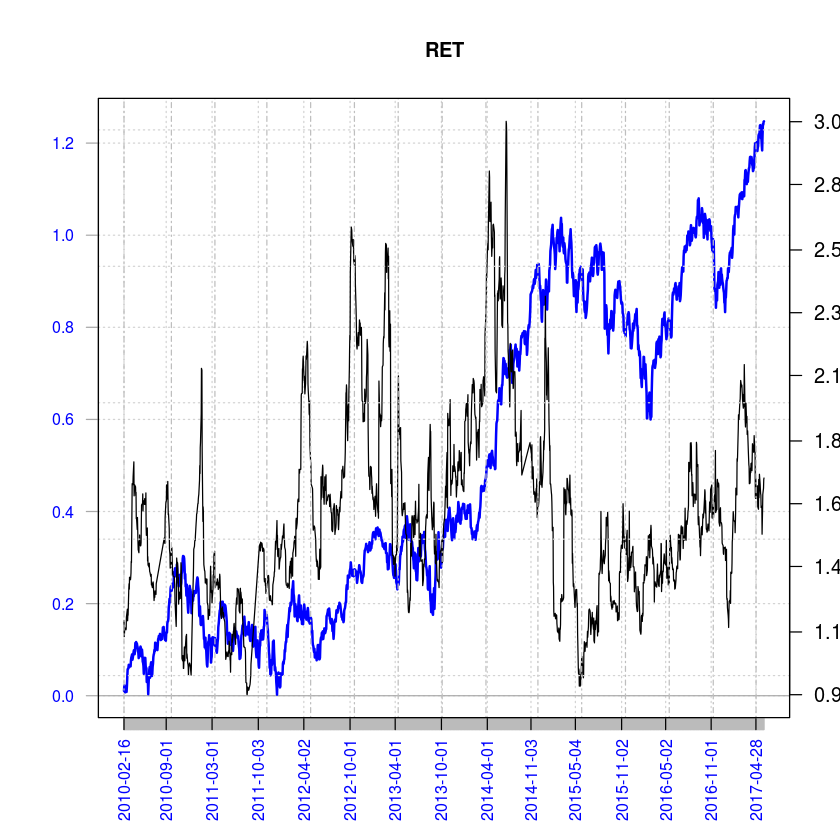

In [14]:
labseq<-round(seq(from=min(niftyRet2$TD), to=max(niftyRet2$TD), length.out=10),2)

par(col.axis='blue')
chart.CumReturns(niftyRet2$RET, col='blue', las=2, ylab=NA)
par(new=T)
plot(niftyRet2$TD, xaxt='n', yaxt='n', main=NA, ylab=NA)
axis(side=4,at=labseq, labels=labseq, col.axis='black', las=2) 